In [1]:
import numpy as np
import pandas as pd

from scipy.stats import trim_mean   # conda install scipy
from statsmodels import robust      # conda install -c conda-forge statsmodels 
import wquantiles                   # pip install wquantiles

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
df_city = pd.read_csv('../../data/diamonds_city_202208201409.csv')
df_clarity = pd.read_csv('../../data/diamonds_clarity_202208201409.csv')
df_color = pd.read_csv('../../data/diamonds_color_202208201409.csv')
df_cut = pd.read_csv('../../data/diamonds_cut_202208201409.csv')
df_dimensions = pd.read_csv('../../data/diamonds_dimensions_202208201409.csv')
df_properties = pd.read_csv('../../data/diamonds_properties_202208201409.csv')
df_transactional = pd.read_csv('../../data/diamonds_transactional_202208201409.csv')

In [3]:
df_diamonds = df_properties.merge(
    df_clarity, on="clarity_id", how="left").merge(
    df_color, on="color_id", how="left").merge(
    df_cut, on="cut_id", how="left").merge(
    df_dimensions, on="index_id", how="left").merge(
    df_transactional, on="index_id", how="left").merge(df_city, on="city_id", how="left")

In [4]:
#reordenamos el orden de las columnas
df_diamonds = df_diamonds[['carat','depth','table','x', 'y', 'z','price', 'city', 'cut', 'color','clarity']]

In [5]:
df_diamonds.info() #compuesto por las 40.455 filas y 16 columnas sin nulos.
df_diamonds.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40455 entries, 0 to 40454
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40455 non-null  float64
 1   depth    40455 non-null  float64
 2   table    40455 non-null  float64
 3   x        40455 non-null  float64
 4   y        40455 non-null  float64
 5   z        40455 non-null  float64
 6   price    40455 non-null  int64  
 7   city     40455 non-null  object 
 8   cut      40455 non-null  object 
 9   color    40455 non-null  object 
 10  clarity  40455 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 3.7+ MB


,carat,depth,table,x,y,z,price,city,cut,color,clarity
0,1.21,62.4,58.0,6.83,6.79,4.25,4268,Kimberly,Premium,J,VS2
1,0.32,63.0,57.0,4.35,4.38,2.75,505,Antwerp,Very Good,H,VS2
2,0.71,65.5,55.0,5.62,5.53,3.65,2686,London,Fair,G,VS1
3,0.41,63.8,56.0,4.68,4.72,3.00,738,New York City,Good,D,SI1
4,1.02,60.5,59.0,6.55,6.51,3.95,4882,Dubai,Ideal,G,SI1


In [6]:
df_diamonds.describe()

,carat,depth,table,x,y,z,price
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,0.797706,61.752841,57.446133,5.729392,5.732819,3.537154,3928.444469
std,0.475544,1.431725,2.233535,1.124453,1.146650,0.697062,3992.416147
min,0.200000,43.000000,43.000000,0.000000,0.000000,0.000000,326.000000
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,945.000000
50%,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000,2397.000000
75%,1.040000,62.500000,59.000000,6.540000,6.540000,4.035000,5331.000000
max,4.500000,79.000000,95.000000,10.230000,58.900000,8.060000,18823.000000


In [7]:
df_diamonds.isna().sum()

carat      0
depth      0
table      0
x          0
y          0
z          0
price      0
city       0
cut        0
color      0
clarity    0
dtype: int64

# EDA

## Numericals

In [8]:
for column in df_diamonds.columns[:7]:
    tmean_column = trim_mean(df_diamonds[column], 0.1)
    print(f'{column} trimmed_mean:', round(tmean_column, 3))

#la media depth parece ser robusta al estar muy próxima a su media normal
#la media table parece ser robusta al estar muy próxima
#con Price aquí sí que parece haber una gran diferencia respecto a su media
#Diferencia a tener en cuenta en Carat respecto a su media

carat trimmed_mean: 0.734
depth trimmed_mean: 61.786
table trimmed_mean: 57.307
x trimmed_mean: 5.657
y trimmed_mean: 5.66
z trimmed_mean: 3.493
price trimmed_mean: 3153.223


In [9]:
for column in df_diamonds.columns[:7]:
    median_column = df_diamonds[column].median()
    mean_column = df_diamonds[column].mean()
    tmean_column = trim_mean(df_diamonds[column], 0.1)
    print(f'{column} median vs mean vs tri_mean:', round(median_column, 2), '//', round(mean_column, 2),
          '//', round(tmean_column, 2))
    
#Depth: media y mediana se encuentran muy próximas. Son buena medida central
#Table: media y mediana se encuentran muy próximas. Son buena medida central
#Price: media y mediana están lejos. Incluso trimmed media de median
#Carat: media y mediana están lejos

# Conclusiones:
# - los gustos de la gente son muy similares o los diseños de los diamantes no dan a lugar a mucha imaginación
# - buscando la forma simétrica de un cuadrado por ser X e Y muy parecidos. Figura de cuadrado.

carat median vs mean vs tri_mean: 0.7 // 0.8 // 0.73
depth median vs mean vs tri_mean: 61.8 // 61.75 // 61.79
table median vs mean vs tri_mean: 57.0 // 57.45 // 57.31
x median vs mean vs tri_mean: 5.69 // 5.73 // 5.66
y median vs mean vs tri_mean: 5.71 // 5.73 // 5.66
z median vs mean vs tri_mean: 3.52 // 3.54 // 3.49
price median vs mean vs tri_mean: 2397.0 // 3928.44 // 3153.22


In [10]:
for column in df_diamonds.columns[:7]:
    std_dev = df_diamonds[column].std()
    std_dev_p = (std_dev / df_diamonds[column].mean())* 100
    print(f'{column} Standard deviation:', round(std_dev, 3), 'que supone un', round(std_dev_p, 2), '% respecto a su media')
    
# cuanto mayor sea la dispersión mayor es la desviación estándar, si no hubiera ninguna variación en los datos, 
# es decir, si fueran todos iguales, la desviación estándar sería cero. 
# La desviación estándar cuantifica la dispersión alrededor de la media aritmética. 
# Informa de la media de distancias que tienen los datos respecto de su media aritmética.
# Si la muestra representara una distribución normal podríamos decir que: 
# el 68% se encuentran en +- una vez la standard deviation respecto a la media
# el 95% se encuentra en +- 1,96 veces la standard deviation respecto a la media

# Puede resultar interesante calcular de cada uno si en muy representativo respecto a la media

#Conclusiones:
# - Depth y Table nos deberían de mostrar resultados muy poco dispersos como ya vimos con su media, y mediana
# - X, Y, Z muestran unas desviaciones no muy altas y lo curioso es que entre ellas son muy similares lo
# que se podría interpretar como proporcionalidad en el diseño de la forma de los diamantes
# - Price y Carat sus desviaciones suponen mucha diferencia, lo que se podría interpretar como que 
# por muy pequeña que sea la variación en sus medidas, varía mucho su precio y algo menos los quilates.

carat Standard deviation: 0.476 que supone un 59.61 % respecto a su media
depth Standard deviation: 1.432 que supone un 2.32 % respecto a su media
table Standard deviation: 2.234 que supone un 3.89 % respecto a su media
x Standard deviation: 1.124 que supone un 19.63 % respecto a su media
y Standard deviation: 1.147 que supone un 20.0 % respecto a su media
z Standard deviation: 0.697 que supone un 19.71 % respecto a su media
price Standard deviation: 3992.416 que supone un 101.63 % respecto a su media


In [13]:
for column in df_diamonds.columns[:7]:
    diamonds_range = df_diamonds[column].max() - df_diamonds[column].min()
    print(f'{column} range:', diamonds_range, ', siendo su mínimo:', df_diamonds[column].min(), 'y su máximo:', 
          df_diamonds[column].max())

# Conclusiones:
# - Extraño que si X e Y estaban tan parejos ahora muestren unos rangos tan dispares. En algunos diseños no cumple
# la proporcionalidad y podría derivarse de peticiones muy específicas.
# - Por lo tanto analizamos cuando x, y, z son máximo y mínimo. Lo mismo con el precio.

carat range: 4.3 , siendo su mínimo: 0.2 y su máximo: 4.5
depth range: 36.0 , siendo su mínimo: 43.0 y su máximo: 79.0
table range: 52.0 , siendo su mínimo: 43.0 y su máximo: 95.0
x range: 10.23 , siendo su mínimo: 0.0 y su máximo: 10.23
y range: 58.9 , siendo su mínimo: 0.0 y su máximo: 58.9
z range: 8.06 , siendo su mínimo: 0.0 y su máximo: 8.06
price range: 18497 , siendo su mínimo: 326 y su máximo: 18823


In [11]:
for column in df_diamonds.columns[:7]:
    per_75 = df_diamonds[column].quantile(0.75)
    per_25 = df_diamonds[column].quantile(0.25)
    iqr = per_75 - per_25
    iqr_perc = (iqr / df_diamonds[column].median())* 100
    print(f'{column} interquartile range:', round(iqr, 3), 'que representa el', round(iqr_perc, 3), '% sobre su mediana')

# Interpretación:
# Muestra la dispersión de valor en la que se encuentran el 50% de los valores más centrales.

# Conclusiones:
# Vemos de nuevo la alta dispersión de los valores en el precio a diferencia de los valores en Depth y/o Table.
# Se podría interpretar que el precio es muy sensible a las medidas del diamante
# X, Y, Z parece que siguen manteniendo esa proporcionalidad.

carat interquartile range: 0.64 que representa el 91.429 % sobre su mediana
depth interquartile range: 1.5 que representa el 2.427 % sobre su mediana
table interquartile range: 3.0 que representa el 5.263 % sobre su mediana
x interquartile range: 1.83 que representa el 32.162 % sobre su mediana
y interquartile range: 1.82 que representa el 31.874 % sobre su mediana
z interquartile range: 1.125 que representa el 31.96 % sobre su mediana
price interquartile range: 4386.0 que representa el 182.979 % sobre su mediana


### Analize Carat

In [19]:
carat = df_diamonds['carat'].unique()
print(sorted(carat))

[0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6, 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.7, 1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8, 1.81, 1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.

In [ ]:
# Mínimos:
df_diamonds[df_diamonds['x']==0] #son 5 filas
#df_diamonds[df_diamonds['y']==0] #son 4 filas
#df_diamonds[df_diamonds['z']==0] #son 16 filas
#df_diamonds[df_diamonds['price']==326] #medidas de x,y,z próximos a su media.

# Máximos:
#df_diamonds[df_diamonds['x']==10.23] #en máximo el precio (18.531) es muy próximo a su máximo
#df_diamonds[df_diamonds['y']==58.9] #llama la atención el valor tan bajo de x (8.09) y pero coincide con max de z(8.06)
#df_diamonds[df_diamonds['z']==8.06] #mismo caso que el anterior. Representa un precio alto que se podría considerar acorde.
#df_diamonds[df_diamonds['price']==18823] #no se corresponde con medidas máximas incluso ni en depth y table.

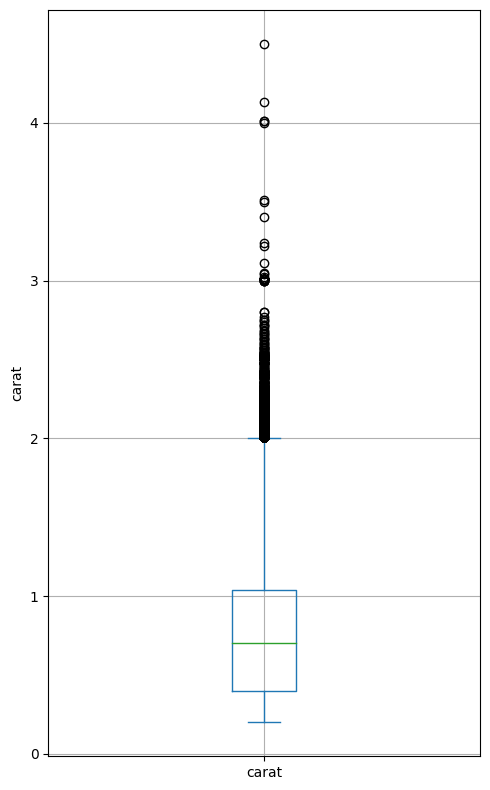

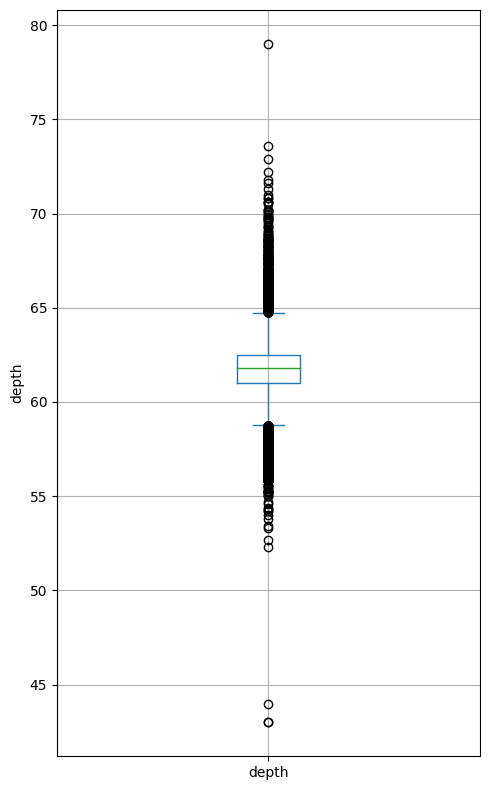

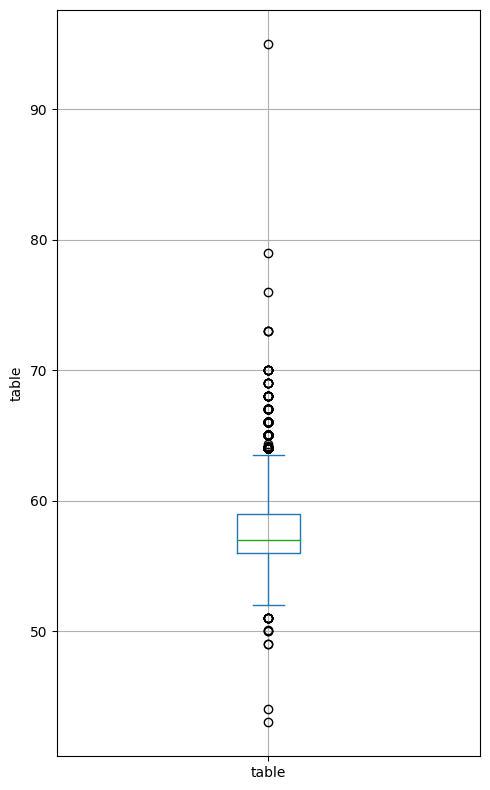

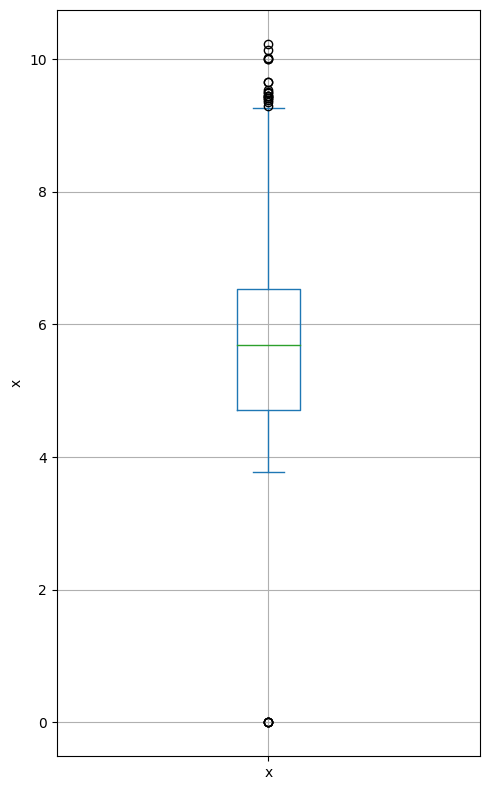

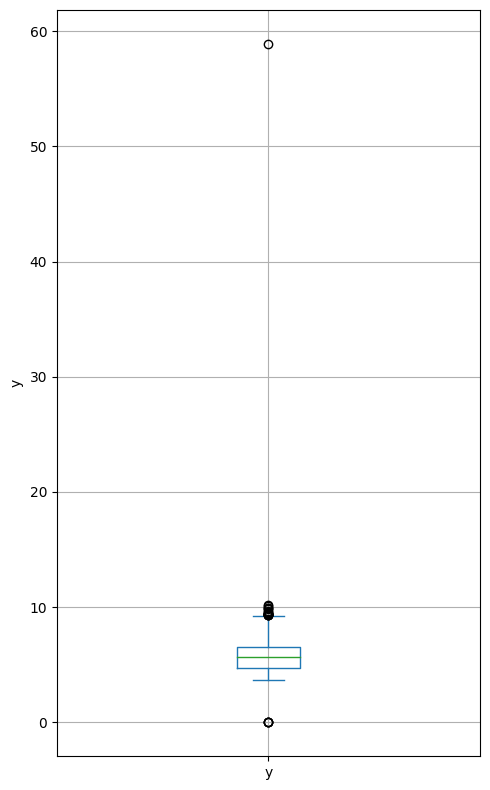

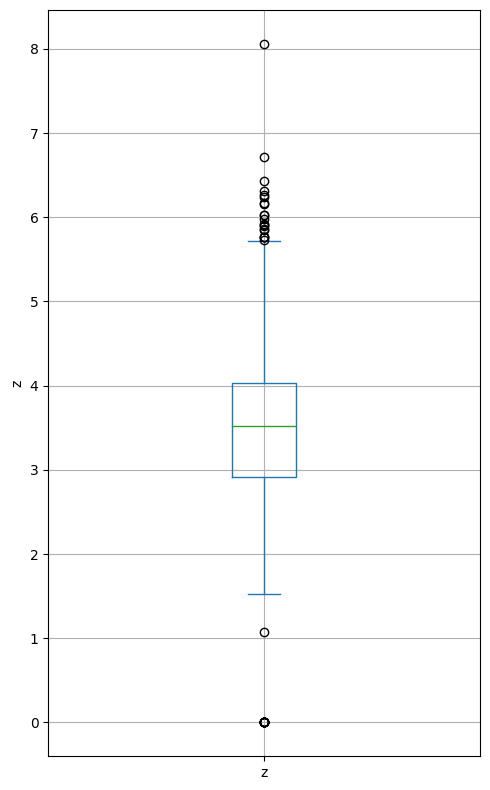

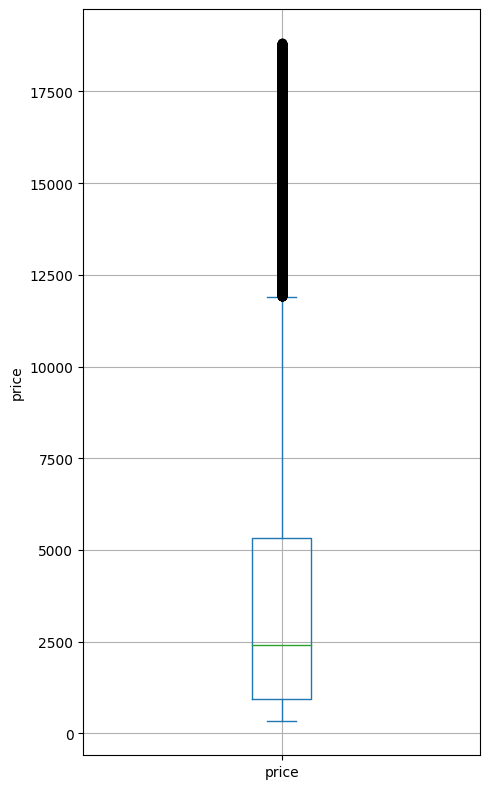

In [20]:
for column in df_diamonds.columns[:7]:
    data = df_diamonds[column]
    ax = data.plot.box(figsize=(5, 8))
    ax.set_ylabel(column)
    #ax.boxplot(data, whis=[0, 100])
    plt.tight_layout()
    plt.grid()
    plt.show()

# Interpretación:
# El interior de la caja marca el límite inferior del percentil 25 y el superior del 75
# La línea interior es la mediana
# Los bigotes pueden llegar a marcar un máximo de +-1,5 veces la desviación stándar.

# Conclusiones:
# Muchas veces el visual únicamente puede llevarnos a engaño debido a las escalas como sucede comparando los gráficos x e Y.
# Con X e Y venimos viendo su alta relación pero visualmente diríamos que los valores de Y están más concentrados que en X.

In [ ]:
for column in df_diamonds.columns[:7]:
    data = df_diamonds[column]
    ax = data.plot.hist(figsize=(12, 8))
    ax.set_xlabel(column)
    plt.tight_layout()
    plt.show()

# Interpretación:
# Tabla de frecuencias de los valores de una feature

# Conclusiones:
# Table, Depth, X, Y, Z mantienen visuales de concentración mientras que Price y Carat muestran cierta similitud
# Veníamos viendo que X e Y eran muy similares pero en el gráfico al usar diferente escala nos podría dar una señal no
# tan similar.

In [ ]:
df_diamonds_bin = df_diamonds.copy()
df_diamonds_bin['binned_x'] = pd.qcut(df_diamonds_bin['x'], q=5, precision=2)
df_diamonds_bin['binned_y'] = pd.qcut(df_diamonds_bin['y'], q=5, precision=2)
df_diamonds_bin['binned_z'] = pd.qcut(df_diamonds_bin['z'], q=5, precision=2)
df_diamonds_bin

In [ ]:
# puede ser interesante analizar como opción, crear bins para sustituir X,Y,Z.

#for column in df_diamonds.columns[3:6]:
    #df_diamonds[f'binned_{column}'] = pd.cut(df_diamonds[column], 10)
    # Los siguientes pasos muestran otra lógica de cómo hacer este proceso pero que por alguna razón no me funcionaba en el loop
    #binnedPopulation = pd.cut(df_diamonds[column], 10)
    #binnedPopulation.head()
    #binnedPopulation.value_counts()
    #binnedPopulation.name = f'binned_{column}'
    #df_bin = pd.concat([df_diamonds, binnedPopulation], axis=1)
    #df_bin = df_bin.sort_values(by=column)
    
#df_diamonds.head()

# Interpretación:
# asignamos un número específico de intervalos (bins) a un feature. Dicho número divide el rango de la muestra en cajitas
# del mismo tamaño por lo que el número de valores que caen en cada intervalo no tienen por qué ser iguales.
# Lo que sucedía en los percentiles es que cada una de las 4 cajas contenía el mismo número de valores.

### Categorical Data

In [ ]:
cols = ['city', 'cut', 'color', 'clarity']

cat_list = []
for col in cols:
    cat = df_diamonds[col].unique()
    cat_num = len(cat)
    cat_dict = {"categorical_variable":col,
                "number_of_possible_values":cat_num,
                "values":cat}
    cat_list.append(cat_dict)
    
categories = pd.DataFrame(cat_list).sort_values(by="number_of_possible_values",
                                                ascending=False).reset_index(drop=True)
categories

### Full Dummies

In [ ]:
# Get.dummies con todos

df_diamonds_dumm = pd.get_dummies(df_diamonds_bin, columns=['cut', 'color', 'clarity', 'city', 'binned_x', 'binned_y', 'binned_z'], drop_first=True)
df_diamonds_dumm

### Mix Label and Dummies

In [ ]:
# Usando tanto get.dummies como label encoding con Cut (Fair, Good, Very Good, Premium, Ideal), 
         # Color from J (worst) to D (best) y Claridad (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)).

In [ ]:
# Label encoding y get.dummies con el resto
encoding_cut = {'Fair':1, 'Good':2, 'Very Good':3, 'Premium':4, 'Ideal':5}
def ordinal_encoding_cut(x):
    for key in encoding_cut:
        if x == key:
            return encoding_cut[key]

In [ ]:
df_diamonds_mix = df_diamonds_bin.copy()

In [ ]:
df_diamonds_mix['cut'] = df_diamonds_mix['cut'].apply(ordinal_encoding_cut)
df_diamonds_mix

In [ ]:
encoding_color = {'J':1, 'I':2, 'H':3, 'G':4, 'F':5, 'E':6, 'D':7}
def ordinal_encoding_color(x):
    for key in encoding_color:
        if x == key:
            return encoding_color[key]

In [ ]:
df_diamonds_mix['color'] = df_diamonds_mix['color'].apply(ordinal_encoding_color)
df_diamonds_mix

In [ ]:
encoding_clarity = {'I1':1, 'SI2':2, 'SI1':3, 'VS2':4, 'VS1':5, 'VVS2':6, 'VVS1':7, 'IF':8}
def ordinal_encoding_clarity(x):
    for key in encoding_clarity:
        if x == key:
            return encoding_clarity[key]

In [ ]:
df_diamonds_mix['clarity'] = df_diamonds_mix['clarity'].apply(ordinal_encoding_clarity)
df_diamonds_mix

In [ ]:
df_diamonds_mix = pd.get_dummies(df_diamonds_mix, columns=['city', 'binned_x', 'binned_y', 'binned_z'], drop_first=True)
df_diamonds_mix

In [ ]:
df_diamonds_mix.info()

### Escalados Full dumm

In [ ]:
# Using scikit-learn .StandardScaler() Only dumm
df_cols = list(df_diamonds_dumm.columns)
scaler_stand = StandardScaler()
df_diamonds_dumm_stand = scaler_stand.fit_transform(df_diamonds_dumm)
df_diamonds_dumm_stand = pd.DataFrame(df_diamonds_dumm_stand, columns=df_cols)
df_diamonds_dumm_stand

In [ ]:
# Using scikit-learn .MinMaxScaler()

scaler_minmax = MinMaxScaler()
df_diamonds_dumm_minmax = scaler_minmax.fit_transform(df_diamonds_dumm)
df_diamonds_dumm_minmax = pd.DataFrame(df_diamonds_dumm_minmax, columns=df_cols)
df_diamonds_dumm_minmax

In [ ]:
# Using scikit-learn .Robust()

scaler_robust = RobustScaler()
df_diamonds_dumm_rob = scaler_robust.fit_transform(df_diamonds_dumm)
df_diamonds_dumm_rob = pd.DataFrame(df_diamonds_dumm_rob, columns=df_cols)
df_diamonds_dumm_rob

### Escalado Mix

In [ ]:
# Using scikit-learn .StandardScaler() Label and dumm
df_cols_mix = list(df_diamonds_mix.columns)
scaler_stand = StandardScaler()
df_diamonds_mix_stand = scaler_stand.fit_transform(df_diamonds_mix)
df_diamonds_mix_stand = pd.DataFrame(df_diamonds_mix_stand, columns=df_cols_mix)
df_diamonds_mix_stand

In [ ]:
# Using scikit-learn .MinMaxScaler()

scaler_minmax = MinMaxScaler()
df_diamonds_mix_minmax = scaler_minmax.fit_transform(df_diamonds_mix)
df_diamonds_mix_minmax = pd.DataFrame(df_diamonds_mix_minmax, columns=df_cols_mix)
df_diamonds_mix_minmax

In [ ]:
# Using scikit-learn .Robust()

scaler_robust = RobustScaler()
df_diamonds_mix_rob = scaler_robust.fit_transform(df_diamonds_mix)
df_diamonds_mix_rob = pd.DataFrame(df_diamonds_mix_rob, columns=df_cols_mix)
df_diamonds_mix_rob

In [ ]:
# Cada caso con un tipo de escaler

# Caso 1: Sin eliminar nada
# Caso 2: Eliminar posibles columnas: columnas de la original o columnas que se han ido incluyendo.
# Caso 3: Eliminar posibles filas: como por ejemplo en las que X, Y y Z valen 0
# Caso 4: eliminando outliers

# CASE 1. Taking all

In [ ]:
X_columns_dumm_stand = list(df_diamonds_dumm_stand.columns.drop('price'))
y_column_dumm_stand = 'price'

In [ ]:
X_diamonds_dumm_stand = df_diamonds_dumm_stand[X_columns_dumm_stand]
y_diamonds_dumm_stand = df_diamonds_dumm_stand[y_column_dumm_stand]

In [ ]:
x_train_dumm_stand, x_test_dumm_stand, y_train_dumm_stand, y_test_dumm_stand = train_test_split(X_diamonds_dumm_stand, y_diamonds_dumm_stand, test_size=0.2, random_state=42)

In [ ]:
# Model definition

#model = linear_model.Lasso()
#model = ElasticNet()
#model = Ridge()
#model = SVR()
#model = SGDRegressor()
#model = LinearRegression()

hyperparameters = model.get_params()

#print(type(model), '\n')
#print('Model hyperparameters:', hyperparameters, '\n')

In [ ]:
# Model training

model.fit(x_train_dumm_stand, y_train_dumm_stand)

print('Model:', model, '\n')
print('Model hyperparameters:', hyperparameters, '\n')
# print('Model coefficients:', model.coef_, '\n')

In [ ]:
predictions = model.predict(x_test_dumm_stand)

In [ ]:
check = pd.DataFrame({'Ground truth':y_test_dumm_stand, 'Predictions':predictions, 'Diff':y_test_dumm_stand-predictions})
#check

In [ ]:
# RMSE calculation

rmse = mean_squared_error(predictions, y_test_dumm_stand, squared=False)
rmse

# Case 2. Delete Columns Mix

In [ ]:
list(df_diamonds_mix_stand.columns)

In [ ]:
df_diamonds_mix_corr = df_diamonds_mix_stand.corr()
df_diamonds_mix_corr

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(df_diamonds_mix_stand.corr(method='pearson'), annot=True, fmt='.2f', ax=ax);

In [ ]:
df_diamonds_mix_stand_uncorr = df_diamonds_mix_stand.drop(['x', 'y', 'z', 'binned_y_(4.55, 5.24]',
 'binned_y_(5.24, 6.08]',
 'binned_y_(6.08, 6.7]',
 'binned_y_(6.7, 58.9]',
 'binned_z_(2.8, 3.22]',
 'binned_z_(3.22, 3.76]',
 'binned_z_(3.76, 4.13]',
 'binned_z_(4.13, 8.06]'], axis=1)
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(df_diamonds_mix_stand_uncorr.corr(), annot=True, vmin=-1, vmax=1)

In [ ]:
X_columns_mix_stand_delete = list(df_diamonds_mix_stand_uncorr.columns.drop('price'))
y_column_mix_stand_delete = 'price'
X_diamonds_mix_stand_delete = df_diamonds_mix_stand_uncorr[X_columns_mix_stand_delete]
y_diamonds_mix_stand_delete = df_diamonds_mix_stand_uncorr[y_column_mix_stand_delete]
x_train_mix_stand, x_test_mix_stand, y_train_mix_stand, y_test_mix_stand = train_test_split(X_diamonds_mix_stand_delete, 
                                                                                                y_diamonds_mix_stand_delete, 
                                                                                                test_size=0.2, random_state=42)

In [ ]:
# Model definition

model = linear_model.Lasso()
#model = ElasticNet()
#model = Ridge()
#model = SVR()
#model = SGDRegressor()
#model = LinearRegression()


hyperparameters = model.get_params()

#print(type(model), '\n')
#print('Model hyperparameters:', hyperparameters, '\n')

# Model training

model.fit(x_train_mix_stand, y_train_mix_stand)

#print('Model:', model, '\n')
#print('Model hyperparameters:', hyperparameters, '\n')
# print('Model coefficients:', model.coef_, '\n')

predictions = model.predict(x_test_mix_stand)

# RMSE calculation

rmse = mean_squared_error(predictions,  y_test_mix_stand, squared=False)
rmse

In [ ]:
regressor = RandomForestRegressor()
hyperparameters = regressor.get_params()
regressor.fit(x_train_mix_stand, y_train_mix_stand)
y_pred = regressor.predict(x_test_mix_stand)
rmse = mean_squared_error(y_pred,  y_test_mix_stand, squared=False)
rmse

# Test

In [ ]:
df_test = pd.read_csv('../../data/diamonds_test.csv')
df_test.drop('id', axis=1, inplace=True)
df_test

## Full dumm

In [ ]:
df_test_bin = df_test.copy()
df_test_bin['binned_x'] = pd.qcut(df_test_bin['x'], q=5, precision=2)
df_test_bin['binned_y'] = pd.qcut(df_test_bin['y'], q=5, precision=2)
df_test_bin['binned_z'] = pd.qcut(df_test_bin['z'], q=5, precision=2)

In [ ]:
df_test_dumm = pd.get_dummies(df_test_bin, columns=['cut', 'color', 'clarity', 'city', 'binned_x', 'binned_y', 'binned_z'], drop_first=True)

In [ ]:
# Using scikit-learn .StandardScaler() Only dumm
df_cols_test = list(df_test_dumm.columns)
scaler_stand = StandardScaler()
df_test_dumm_stand = scaler_stand.fit_transform(df_test_dumm)
df_test_dumm_stand = pd.DataFrame(df_test_dumm_stand, columns=df_cols_test)

In [ ]:
predictions_test = model.predict(df_test_dumm_stand)

In [ ]:
solucion = pd.DataFrame(predictions_test, columns = ['Price'])
solucion.index.names = ['id']
solucion

In [ ]:
solucion.to_csv('../../data/results.csv')

### Mix

In [ ]:
df_test_mix = df_test_bin.copy()

In [ ]:
df_test_mix['cut'] = df_test_mix['cut'].apply(ordinal_encoding_cut)
df_test_mix['color'] = df_test_mix['color'].apply(ordinal_encoding_color)
df_test_mix['clarity'] = df_test_mix['clarity'].apply(ordinal_encoding_clarity)

In [ ]:
df_test_mix = pd.get_dummies(df_test_mix, columns=['city', 'binned_x', 'binned_y', 'binned_z'], drop_first=True)

In [ ]:
list(df_test_mix.columns)

In [ ]:
df_test_mix_uncorr = df_test_mix.drop(['x', 'y', 'z', 'binned_x_(4.56, 5.24]',
 'binned_x_(5.24, 6.09]',
 'binned_x_(6.09, 6.7]',
 'binned_x_(6.7, 10.74]',
 'binned_y_(4.56, 5.25]',
 'binned_y_(5.25, 6.09]',
 'binned_y_(6.09, 6.7]',
 'binned_y_(6.7, 31.8]',
 'binned_z_(2.81, 3.23]',
 'binned_z_(3.23, 3.77]',
 'binned_z_(3.77, 4.13]',
 'binned_z_(4.13, 31.8]'], axis=1)